In [61]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv("Road Accident Data.csv")
df

,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,200901BS70001,1/1/2021,Jan,Thursday,2021,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,200901BS70002,1/5/2021,Jan,Monday,2021,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,200901BS70003,1/4/2021,Jan,Sunday,2021,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,200901BS70004,1/5/2021,Jan,Monday,2021,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,200901BS70005,1/6/2021,Jan,Tuesday,2021,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307968,201091NM01760,2/18/2022,Feb,Thursday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.374005,Daylight,...,2,1,Northern,Dry,Single carriageway,60,7:00,Rural,Fine no high winds,Car
307969,201091NM01881,2/21/2022,Feb,Sunday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.232273,Darkness - no lighting,...,1,1,Northern,Frost or ice,Single carriageway,60,3:00,Rural,Fine no high winds,Car
307970,201091NM01935,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Slight,57.585044,Daylight,...,1,3,Northern,Frost or ice,Single carriageway,30,9:38,Rural,Fine no high winds,Car
307971,201091NM01964,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Serious,57.214898,Darkness - no lighting,...,1,2,Northern,Wet or damp,Single carriageway,60,18:25,Rural,Fine no high winds,Motorcycle over 500cc


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              307973 non-null  object 
 1   Accident Date               307973 non-null  object 
 2   Month                       307973 non-null  object 
 3   Day_of_Week                 307973 non-null  object 
 4   Year                        307973 non-null  int64  
 5   Junction_Control            307973 non-null  object 
 6   Junction_Detail             307973 non-null  object 
 7   Accident_Severity           307973 non-null  object 
 8   Latitude                    307973 non-null  float64
 9   Light_Conditions            307973 non-null  object 
 10  Local_Authority_(District)  307973 non-null  object 
 11  Carriageway_Hazards         5424 non-null    object 
 12  Longitude                   307973 non-null  float64
 13  Number_of_Casu

In [9]:
df.describe()

,Year,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000
mean,2021.468934,52.487005,-1.368884,1.356882,1.829063,38.866037
std,0.499035,1.339011,1.356092,0.815857,0.710477,14.032933
min,2021.000000,49.914488,-7.516225,1.000000,1.000000,10.000000
25%,2021.000000,51.485248,-2.247937,1.000000,1.000000,30.000000
50%,2021.000000,52.225943,-1.349258,1.000000,2.000000,30.000000
75%,2022.000000,53.415517,-0.206810,1.000000,2.000000,50.000000
max,2022.000000,60.598055,1.759398,48.000000,32.000000,70.000000


In [ ]:
print(df.isnull().sum())


Accident_Index                     0
Accident Date                      0
Month                              0
Day_of_Week                        0
Year                               0
Junction_Control                   0
Junction_Detail                    0
Accident_Severity                  0
Latitude                           0
Light_Conditions                   0
Local_Authority_(District)         0
Carriageway_Hazards           302549
Longitude                          0
Number_of_Casualties               0
Number_of_Vehicles                 0
Police_Force                       0
Road_Surface_Conditions          317
Road_Type                       1534
Speed_limit                        0
Time                              17
Urban_or_Rural_Area                0
Weather_Conditions              6057
Vehicle_Type                       0
dtype: int64


In [11]:
print(df['Carriageway_Hazards'].unique())


[nan 'Pedestrian in carriageway - not injured' 'Other object on road'
 'Any animal in carriageway (except ridden horse)' 'Previous accident'
 'Vehicle load on road']


In [12]:
print(df['Road_Type'].unique())


['One way street' 'Single carriageway' 'Dual carriageway' 'Roundabout'
 'Slip road' nan]


In [14]:
print(df['Road_Surface_Conditions'].unique())


['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep' nan]


In [15]:
print(df['Weather_Conditions'].unique())


['Fine no high winds' 'Other' 'Raining no high winds'
 'Snowing no high winds' 'Fine + high winds' 'Raining + high winds' nan
 'Snowing + high winds' 'Fog or mist']


In [ ]:
df['Accident Date'] = pd.to_datetime(df['Accident Date'])


ValueError: unconverted data remains when parsing with format "%H:%M": ":00", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [57]:
df = df.sort_values(by='Accident Date')
df


,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Season,Is_Weekend
0,200901BS70001,2021-01-01,Jan,Thursday,2021,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,...,Metropolitan Police,Dry,One way street,30,15:11:00,Urban,Fine no high winds,Car,Winter,False
113126,2.01E+12,2021-01-01,Jan,Thursday,2021,Data missing or out of range,Not at junction or within 20 metres,Slight,50.716192,Darkness - lights lit,...,Hampshire,Dry,Single carriageway,30,01:20:00,Urban,Fine no high winds,Car,Winter,False
63710,2009170S10189,2021-01-01,Jan,Thursday,2021,Auto traffic signal,T or staggered junction,Slight,54.560816,Darkness - lights lit,...,Cleveland,Dry,Single carriageway,30,20:45:00,Urban,Fine no high winds,Car,Winter,False
16841,200901TX20018,2021-01-01,Jan,Thursday,2021,Give way or uncontrolled,Mini-roundabout,Slight,51.497357,Darkness - lights lit,...,Metropolitan Police,Dry,Single carriageway,30,19:05:00,Urban,Fine no high winds,Car,Winter,False
159165,200997BA70101,2021-01-01,Jan,Thursday,2021,Data missing or out of range,Not at junction or within 20 metres,Slight,55.868520,Darkness - lights lit,...,Strathclyde,Wet or damp,Dual carriageway,60,04:01:00,Urban,Snowing no high winds,Car,Winter,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218866,201014A211610,2022-12-31,Dec,Friday,2022,Give way or uncontrolled,T or staggered junction,Slight,53.509198,Darkness - lights lit,...,South Yorkshire,Dry,Dual carriageway,40,00:40:00,Urban,Fine no high winds,Car,Autumn,True
244098,20103102D3314,2022-12-31,Dec,Friday,2022,Give way or uncontrolled,T or staggered junction,Slight,52.958000,Darkness - lighting unknown,...,Nottinghamshire,Dry,Single carriageway,30,22:00:00,Urban,Fine no high winds,Car,Autumn,True
260934,20104100K0645,2022-12-31,Dec,Friday,2022,Give way or uncontrolled,Roundabout,Slight,51.726729,Daylight,...,Hertfordshire,Wet or damp,Slip road,70,13:56:00,Rural,Fine no high winds,Car,Autumn,True
229514,201020S500580,2022-12-31,Dec,Friday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,52.396832,Darkness - lights lit,...,West Midlands,Wet or damp,Single carriageway,30,17:15:00,Urban,Fine no high winds,Car,Autumn,True


In [27]:
df['Weather_Conditions'] = df['Weather_Conditions'].fillna(method='ffill')
print("num of nulls :", df['Weather_Conditions'].isnull().sum())


num of nulls : 0


C:\Users\elsay\AppData\Local\Temp\ipykernel_1012\2588408013.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Weather_Conditions'] = df['Weather_Conditions'].fillna(method='ffill')


In [29]:
most_common_time = df['Time'].mode()[0]
df['Time'] = df['Time'].fillna(most_common_time)
print("num of nulls :", df['Time'].isnull().sum())


num of nulls : 0


In [32]:
most_common = df['Road_Type'].mode()[0]
df['Road_Type'] = df['Road_Type'].fillna(most_common)

print("num of nulls :", df['Road_Type'].isnull().sum())


num of nulls : 0


In [ ]:
df['Carriageway_Hazards'] = df['Carriageway_Hazards'].fillna('No hazard')
print("num of nulls :", df['Carriageway_Hazards'].isnull().sum())



In [38]:
# تحويل عمود 'Accident Date' إلى datetime إذا لم يكن بالفعل
df['Accident Date'] = pd.to_datetime(df['Accident Date'])

# استخراج الفصل من تاريخ الحادث
def get_season(month, day):
    if (month == 3 and day >= 21) or (4 <= month <= 6) or (month == 6 and day <= 20):
        return 'Spring'
    elif (month == 6 and day >= 21) or (7 <= month <= 9) or (month == 9 and day <= 20):
        return 'Summer'
    elif (month == 9 and day >= 21) or (10 <= month <= 12) or (month == 12 and day <= 20):
        return 'Autumn'
    else:
        return 'Winter'

# تطبيق دالة الفصول على البيانات
df['Season'] = df['Accident Date'].apply(lambda x: get_season(x.month, x.day))

# ملء القيم الفاضية بناءً على الفصل (من خلال الأكثر تكرارًا لكل فصل)
df['Road_Surface_Conditions'] = df.groupby('Season')['Road_Surface_Conditions'].transform(lambda x: x.fillna(x.mode()[0]))

# عرض الصفوف التي تحتوي على قيم مفقودة بعد التعبئة
print(df[df['Road_Surface_Conditions'].isnull()])
print("num of nulls :", df['Road_Surface_Conditions'].isnull().sum())



Empty DataFrame
Columns: [Accident_Index, Accident Date, Month, Day_of_Week, Year, Junction_Control, Junction_Detail, Accident_Severity, Latitude, Light_Conditions, Local_Authority_(District), Carriageway_Hazards, Longitude, Number_of_Casualties, Number_of_Vehicles, Police_Force, Road_Surface_Conditions, Road_Type, Speed_limit, Time, Urban_or_Rural_Area, Weather_Conditions, Vehicle_Type, Season]
Index: []

[0 rows x 24 columns]
num of nulls : 0


In [40]:
print(df.isnull().sum())


Accident_Index                0
Accident Date                 0
Month                         0
Day_of_Week                   0
Year                          0
Junction_Control              0
Junction_Detail               0
Accident_Severity             0
Latitude                      0
Light_Conditions              0
Local_Authority_(District)    0
Carriageway_Hazards           0
Longitude                     0
Number_of_Casualties          0
Number_of_Vehicles            0
Police_Force                  0
Road_Surface_Conditions       0
Road_Type                     0
Speed_limit                   0
Time                          0
Urban_or_Rural_Area           0
Weather_Conditions            0
Vehicle_Type                  0
Season                        0
dtype: int64


In [ ]:
# إضافة عمود 'isweekend' لتحديد إذا كان اليوم هو عطلة نهاية الأسبوع (السبت أو الأحد)
df['Is_Weekend'] = df['Accident Date'].dt.dayofweek >= 5  # 5 = Saturday, 6 = Sunday


In [58]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307973 entries, 0 to 234930
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident_Index              307973 non-null  object        
 1   Accident Date               307973 non-null  datetime64[ns]
 2   Month                       307973 non-null  object        
 3   Day_of_Week                 307973 non-null  object        
 4   Year                        307973 non-null  int64         
 5   Junction_Control            307973 non-null  object        
 6   Junction_Detail             307973 non-null  object        
 7   Accident_Severity           307973 non-null  object        
 8   Latitude                    307973 non-null  float64       
 9   Light_Conditions            307973 non-null  object        
 10  Local_Authority_(District)  307973 non-null  object        
 11  Carriageway_Hazards         307973 non-null 

In [59]:
def is_peak_hour(time):
    # تحويل الوقت إلى ساعة
    hour = time.hour
    # ساعات الذروة من 7:00 AM إلى 9:00 AM ومن 4:00 PM إلى 6:00 PM
    if (7 <= hour < 9) or (16 <= hour < 18):
        return True
    else:
        return False

# إضافة عمود 'is_peak_hour' بناءً على وقت الحادث
df['is_peak_hour'] = df['Time'].apply(is_peak_hour)

In [ ]:
# مثال على عدد المصابين
Q1 = df['Number_of_Casualties'].quantile(0.25)
Q3 = df['Number_of_Casualties'].quantile(0.75)
IQR = Q3 - Q1

# تحديد الـ outliers
outliers = df[(df['Number_of_Casualties'] < (Q1 - 1.5 * IQR)) | (df['Number_of_Casualties'] > (Q3 + 1.5 * IQR))]

print("عدد القيم الشاذة:", len(outliers))
print(outliers[['Accident_Index', 'Number_of_Casualties']])


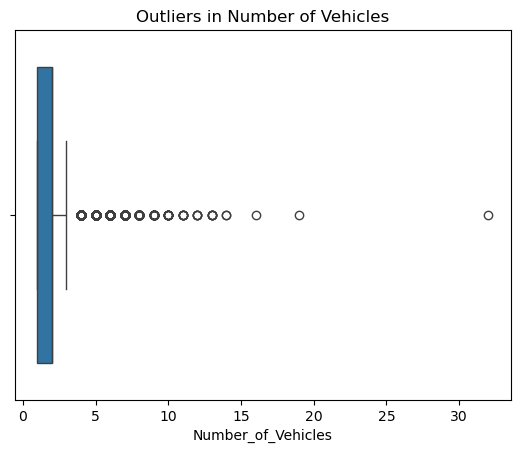

In [62]:
sns.boxplot(x=df['Number_of_Vehicles'])
plt.title('Outliers in Number of Vehicles')
plt.show()

In [63]:
# مثال على عدد المصابين
Q1 = df['Number_of_Casualties'].quantile(0.25)
Q3 = df['Number_of_Casualties'].quantile(0.75)
IQR = Q3 - Q1

# تحديد الـ outliers
outliers = df[(df['Number_of_Casualties'] < (Q1 - 1.5 * IQR)) | (df['Number_of_Casualties'] > (Q3 + 1.5 * IQR))]

print("عدد القيم الشاذة:", len(outliers))
print(outliers[['Accident_Index', 'Number_of_Casualties']])


عدد القيم الشاذة: 72880
       Accident_Index  Number_of_Casualties
6963    200901JI76752                     4
32060   200905EE32669                     4
154063       2.01E+12                     2
32402   200905FF29982                     2
122594       2.01E+12                     2
...               ...                   ...
208559       2.01E+12                     2
244052  20103102D3142                     2
246837  201032D401710                     2
167415  201001EO40807                     2
244162  20103104A3274                     3

[72880 rows x 2 columns]
